In [1]:
# plot cumulative entries by race, from the illinois-state foia data (todo- data docs)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [32]:

# load the excel data into a pandas dataframe
statewide_counts_path = 'data/18-1942-StatewideGangs-7_16_2018.xlsx'
gangDB = pd.read_excel(statewide_counts_path,sheet_name='gangDB')
print("headings")
print(list(gangDB)) # headings

# get the list of race identifiers tracked in the state list
unique_identifiers = []
for entry in gangDB['RAC']:
    if not(entry in unique_identifiers):
        unique_identifiers.append(entry)
print("race identifiers: ")
print(unique_identifiers)
color_code = ['#ffb000','#fe8500','#5392ff','#9b82f3','#ff509e'] # #95d13c 5392ff, #71cddd #ff509e 34bc6e# manually chosen colors (shape matched to 'unique_identifiers')
print("color code: ")
print(color_code) 

# ####### build a more convenient data structure for plotting
N_races = len(unique_identifiers)
startYear = gangDB['EnterYear'].iloc[0]
endYear = gangDB['EnterYear'].iloc[-1]
N_years = endYear - startYear + 1
surveillanceTimeSeries = np.zeros((N_races, N_years)) # data structure for plotting entries by year for each race
year2idx = dict(zip(np.arange(startYear,endYear+1),np.arange(0,N_years))) # for convenient translation between year and index
for race_idx,race_ID in enumerate(unique_identifiers):
    for idx,val in enumerate(gangDB['RAC']):
        if race_ID==val:
            year = gangDB['EnterYear'].iloc[idx]
            yearIdx = year2idx[year]
            numEntries = gangDB['Number'].iloc[idx]
            surveillanceTimeSeries[race_idx][yearIdx] = numEntries
print("size of the numpy time series array: ")
print(np.shape(surveillanceTimeSeries))




headings
[u'SEX', u'RAC', u'EnterYear', u'Number']
race identifiers: 
[u'W', u'B', u'U', u'I', u'A']
color code: 
['#ffb000', '#fe8500', '#5392ff', '#9b82f3', '#ff509e']
size of the numpy time series array: 
(5L, 26L)


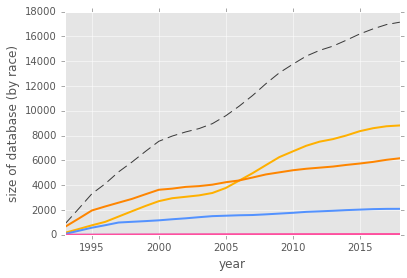

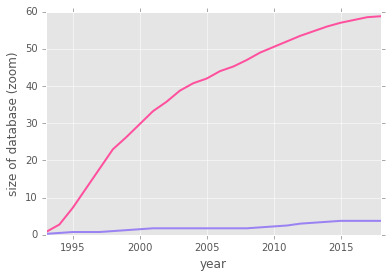

In [52]:
xx = np.unique(gangDB['EnterYear']) # get entry-year data for xaxis range

# total size over all race identifiers
yy_total = np.zeros(np.shape(xx)) # init
for idx,ID in enumerate(unique_identifiers):
    yy_total += np.cumsum(smooth(surveillanceTimeSeries[idx][:],4))

# plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for idx,ID in enumerate(unique_identifiers):
    yy = np.cumsum(smooth(surveillanceTimeSeries[idx][:],4))
    ax.plot(xx,yy,color=color_code[idx],linewidth=2)
ax.plot(xx,yy_total,dashes=[10,5,10,5],color='black',alpha=0.75,linewidth=1) # add the total line
ax.set_xlim(np.min(xx),np.max(xx))
ax.set_xlabel('year')
ax.set_ylabel('size of database (by race)')
plt.show()

# just the small categories, for a blowup
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for idx,ID in enumerate(unique_identifiers[-2:]):
    yy = np.cumsum(smooth(surveillanceTimeSeries[idx+3][:],4))
    ax.plot(xx,yy,color=color_code[idx+3],linewidth=2) # offset manually for color selection
ax.set_xlim(np.min(xx),np.max(xx))
ax.set_xlabel('year')
ax.set_ylabel('size of database (zoom)')
plt.show()



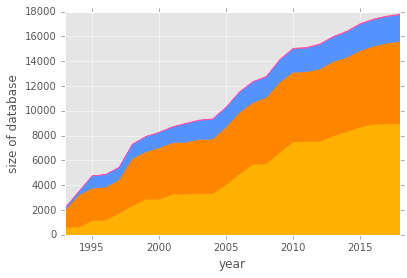

In [36]:
# print stacked area chart

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

yy_lower = np.zeros(np.shape(xx)) # init
for idx,ID in enumerate(unique_identifiers):
    yy_upper = yy_lower + np.cumsum(surveillanceTimeSeries[idx][:])    
    ax.fill_between(xx,yy_lower,yy_upper,color=color_code[idx],alpha=1)
    yy_lower = yy_upper
    
ax.set_xlim(np.min(xx),np.max(xx))
ax.set_xlabel('year')
ax.set_ylabel('size of database')
plt.show()

(1L, 26L)
(5L, 26L)


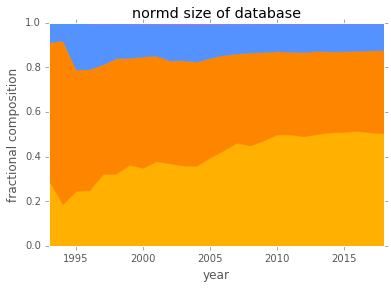

In [35]:
# print norm'd stack (racial percentage vs year)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

cumSurveillanceTimeSeries = surveillanceTimeSeries.copy() # initialize size
for idx in range(len(unique_identifiers)):
    cumSurveillanceTimeSeries[idx] = np.cumsum(surveillanceTimeSeries[idx][:])
total_entries = np.sum(cumSurveillanceTimeSeries,0)
total_entries = np.reshape(total_entries, (1,len(total_entries)))
print(np.shape(total_entries))
print(np.shape(cumSurveillanceTimeSeries))
normSurveillanceTimeSeries = cumSurveillanceTimeSeries / np.tile(total_entries,(len(unique_identifiers),1))


yy_lower = np.zeros(np.shape(xx)) # init
for idx,ID in enumerate(unique_identifiers):
    yy_upper = yy_lower + normSurveillanceTimeSeries[idx][:]
    ax.fill_between(xx,yy_lower,yy_upper,color=color_code[idx])
    yy_lower = yy_upper
    
ax.set_xlim(np.min(xx),np.max(xx))
ax.set_xlabel('year')
ax.set_ylabel('fractional composition')
ax.set_title('normd size of database')
ax.set_ylim(0,1)
plt.show()
